In [1]:
import meep as mp
import meep.adjoint as mpa
from meep import Animate2D
import numpy as np
from autograd import numpy as npa
from autograd import tensor_jacobian_product
import nlopt
from matplotlib import pyplot as plt

mp.verbosity(0)
Si = mp.Medium(index=3.4)
SiO2 = mp.Medium(index=1.44)

In [2]:
waveguide_width = 0.5
design_region_width = 2.5
design_region_height = 2.5

waveguide_length = 0.5
pml_size = 1.0
resolution = 10
design_region_resolution = int(1 * resolution)

In [3]:
Sx = 2 * pml_size + 2 * waveguide_length + design_region_width
Sy = 2 * pml_size + design_region_height + 0.5
cell_size = mp.Vector3(Sx, Sy)

pml_layers = [mp.PML(pml_size)]

fcen = 1 / 1.55
width = 0.1
fwidth = width * fcen
source_center = [-Sx / 2 + pml_size + waveguide_length / 3, 0, 0]
source_size = mp.Vector3(0, 2, 0)
kpoint = mp.Vector3(1, 0, 0)
src = mp.GaussianSource(frequency=fcen, fwidth=fwidth)
source = [
    mp.EigenModeSource(
        src,
        eig_band=1,
        direction=mp.NO_DIRECTION,
        eig_kpoint=kpoint,
        size=source_size,
        center=source_center,
    )
]

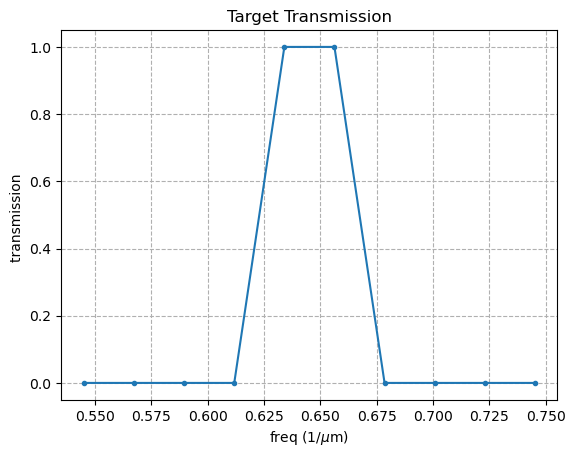

In [4]:
##
Nf = 10
frequencies =  np.linspace(fcen - 0.1, fcen + 0.1, Nf)
def T_target(freq):
    l = len(freq)
    output = np.zeros(l)
    df = 0.03
    ids = np.argwhere(np.abs(freq-fcen)<df).flatten()
    output[ids] = 1
    return output
trans = T_target(frequencies)
plt.figure()
plt.plot(frequencies, trans,'.-')
plt.title('Target Transmission')
plt.xlabel('freq (1/$\mu$m) ')
plt.ylabel('transmission ')

# Display grid
plt.grid(True,linestyle='dashed')
plt.show()

In [5]:
Nx = int(design_region_resolution * design_region_width) + 1
Ny = int(design_region_resolution * design_region_height) + 1

design_variables = mp.MaterialGrid(mp.Vector3(Nx, Ny), SiO2, Si, grid_type="U_MEAN")
design_region = mpa.DesignRegion(
    design_variables,
    volume=mp.Volume(
        center=mp.Vector3(),
        size=mp.Vector3(design_region_width, design_region_height, 0),
    ),
)

In [6]:
minimum_length = 0.09  # minimum length scale (microns)
eta_i = (
    0.5  # blueprint (or intermediate) design field thresholding point (between 0 and 1)
)
eta_e = 0.55  # erosion design field thresholding point (between 0 and 1)
eta_d = 1 - eta_e  # dilation design field thresholding point (between 0 and 1)
filter_radius = mpa.get_conic_radius_from_eta_e(minimum_length, eta_e)
print(filter_radius)


0.20124611797498096


In [7]:
def mapping(x, eta, beta):
    # filter
    filtered_field = mpa.conic_filter(
        x,
        filter_radius,
        design_region_width,
        design_region_height,
        design_region_resolution,
    )

    # projection
    projected_field = mpa.tanh_projection(filtered_field, beta, eta)

    # interpolate to actual materials
    return projected_field.flatten()

In [8]:
geometry = [
    mp.Block(
        center=mp.Vector3(x=-Sx / 4), material=Si, size=mp.Vector3(Sx / 2, 1, 0)
    ),  # horizontal waveguide
    mp.Block(
        center=mp.Vector3(x = Sx / 4), material=Si, size=mp.Vector3(Sx / 2, 1, 0)
    ),  # right waveguide
    mp.Block(
        center=design_region.center, size=design_region.size, material=design_variables
    ), 
]
sim = mp.Simulation(
    cell_size=cell_size,
    boundary_layers=pml_layers,
    geometry=geometry,
    sources=source,
    default_material=SiO2,
    resolution=resolution,
    eps_averaging=False,
)

In [9]:
mode = 1

TE0 = mpa.EigenmodeCoefficient(
    sim,
    mp.Volume(
        center=mp.Vector3(x=-Sx / 2 + pml_size + 2 * waveguide_length / 3),
        size=mp.Vector3(y=2),
    ),
    mode,
)
TE_right = mpa.EigenmodeCoefficient(
    sim,
    mp.Volume(
        center=mp.Vector3(x = Sx / 2 - pml_size - 2 * waveguide_length / 3),
        size=mp.Vector3(y=2),
    ),
    mode,
)
ob_list = [TE0, TE_right]


def J(source, right):
    #power = npa.abs(right / source) ** 2
    power = -(npa.abs(right / source) ** 2 - trans)**2
    return npa.mean(power)

In [10]:
opt = mpa.OptimizationProblem(
    simulation=sim,
    objective_functions=J,
    objective_arguments=ob_list,
    design_regions=[design_region],
    frequencies=frequencies
)

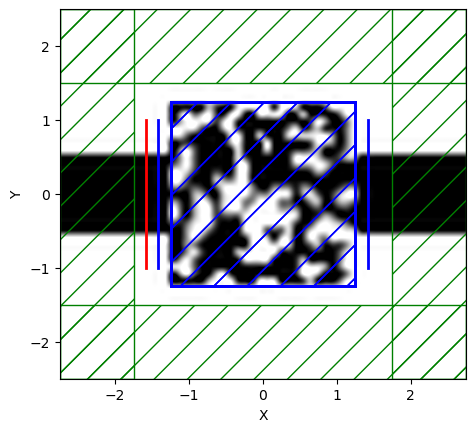

In [11]:
%matplotlib inline
plt.figure()
rho_vector = np.random.rand(Nx * Ny)
opt.update_design([mapping(rho_vector, eta_i, 1e3)])
opt.plot2D(True)

In [12]:
evaluation_history = []
cur_iter = [0]


def f(v, gradient, cur_beta):
    print("Current iteration: {}".format(cur_iter[0] + 1))

    f0, dJ_du = opt([mapping(v, eta_i, cur_beta)])  # compute objective and gradient

    if gradient.size > 0:
        gradient[:] = tensor_jacobian_product(mapping, 0)(
            v, eta_i, cur_beta, np.sum(dJ_du, axis=1)
        )  # backprop

    evaluation_history.append(np.real(f0))

    cur_iter[0] = cur_iter[0] + 1

    return np.real(f0)

Current iteration: 1
Starting forward run...


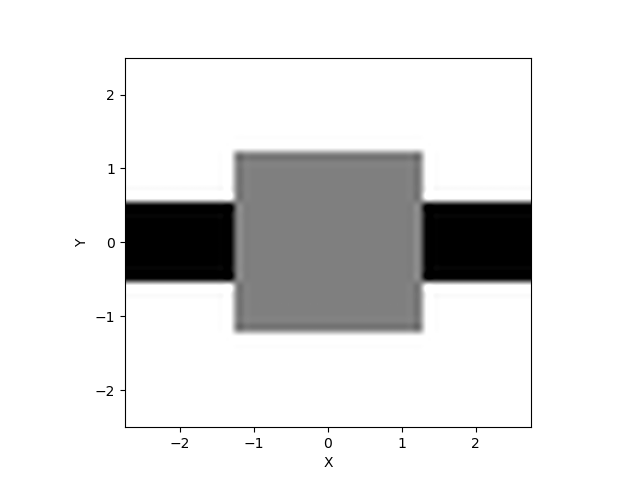

Starting adjoint run...
Calculating gradient...
Current iteration: 2
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current iteration: 3
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current iteration: 4
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current iteration: 5
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current iteration: 6
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current iteration: 7
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current iteration: 8
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current iteration: 9
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current iteration: 10
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current iteration: 11
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current iteration: 1

In [13]:
%matplotlib ipympl

# Create the animation
animate = Animate2D(
    fields=None,
    realtime=True,
    eps_parameters={'contour': False, 'alpha': 1, 'frequency': 1/1.55},
    plot_sources_flag=False,
    plot_monitors_flag=False,
    plot_boundaries_flag=False,
    update_epsilon=True,  # required for the geometry to update dynamically
    nb=True         # required if running in a Jupyter notebook
)
# This will trigger the animation at the end of each simulation
opt.step_funcs=[mp.at_end(animate)]

algorithm = nlopt.LD_MMA
n = Nx * Ny  # number of parameters

# Initial guess
x = np.ones((n,)) * 0.5

# lower and upper bounds
lb = np.zeros((Nx * Ny,))
ub = np.ones((Nx * Ny,))

cur_beta = 4
beta_scale = 2
num_betas = 6
update_factor = 12
for iters in range(num_betas):
    solver = nlopt.opt(algorithm, n)
    solver.set_lower_bounds(lb)
    solver.set_upper_bounds(ub)
    solver.set_max_objective(lambda a, g: f(a, g, cur_beta))
    solver.set_maxeval(update_factor)
    x[:] = solver.optimize(x)
    cur_beta = cur_beta * beta_scale
    print("Current ite_beta: {}".format(iters + 1))
    print("Current beta: {}".format(cur_beta))

In [14]:
animate.to_jshtml(fps=5)

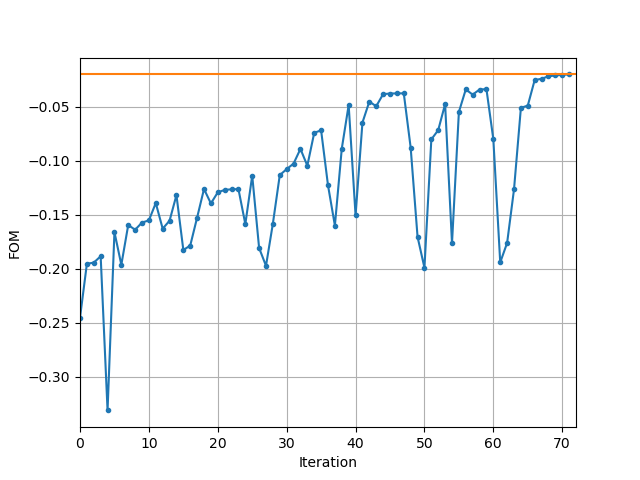

FOM = -0.019840184151868473


In [15]:
plt.figure()
plt.plot(evaluation_history, ".-")
plt.grid()
#plt.yticks(np.arange(0, 1, 0.1))
plt.xlabel("Iteration")
plt.ylabel("FOM")
plt.plot([0,72],[np.max(evaluation_history),np.max(evaluation_history)])
plt.xlim([0,72])
#plt.ylim([0,1.1])
plt.show()
print('FOM =', evaluation_history[-1] )

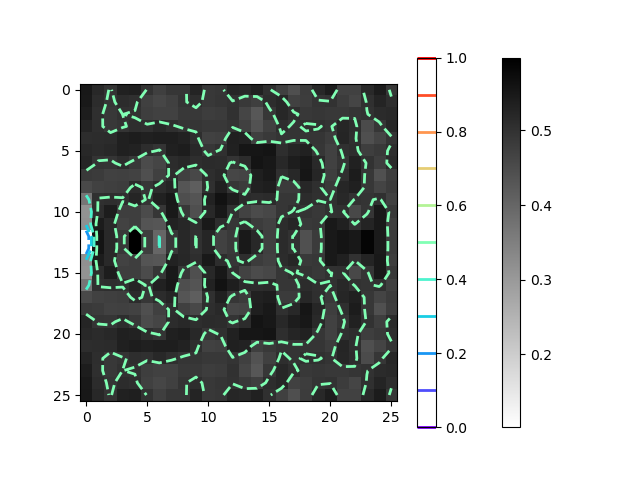

In [16]:
plt.figure()
eps_design = np.rot90(x.reshape(Nx,Ny))
plt.imshow(eps_design,cmap='binary')
#plt.clim([0,1])
plt.colorbar()
plt.contour(eps_design,linewidths=2,cmap='rainbow',levels=np.linspace(0,1,11),linestyles='dashed')
plt.colorbar()
plt.show()

Starting forward run...


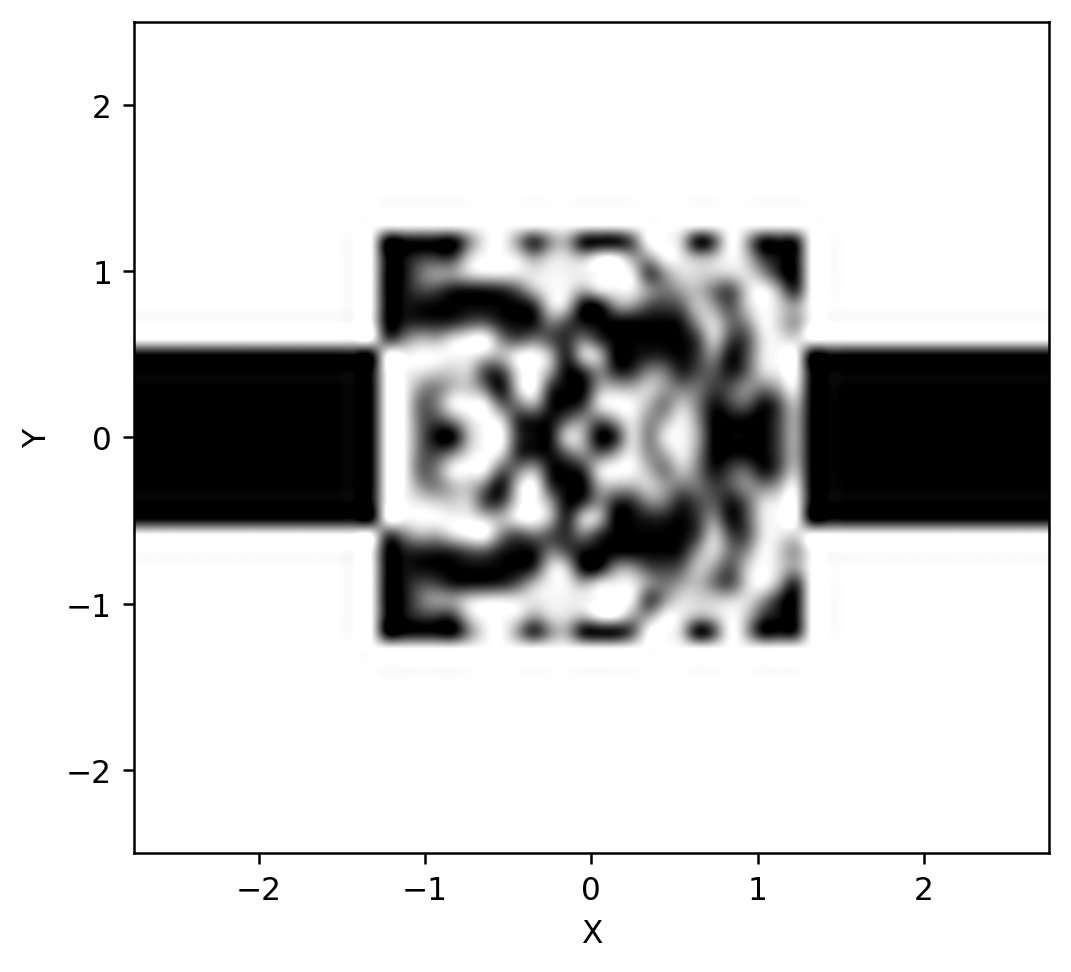

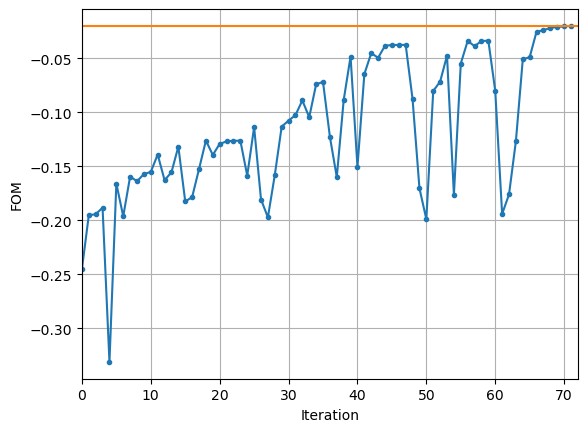

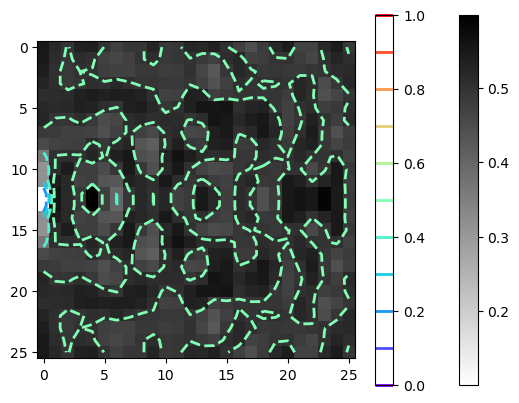

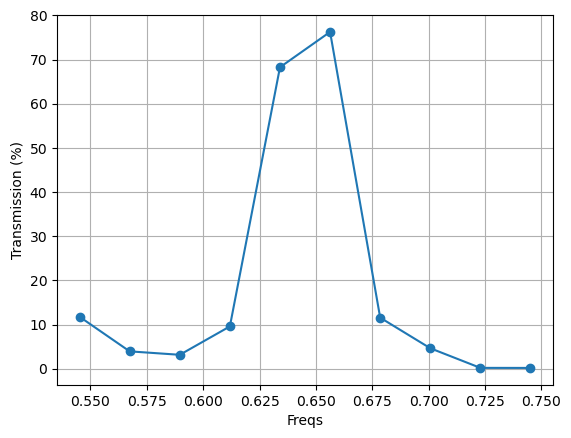

In [17]:
%matplotlib inline
#forward run to pull the objective function parameters and calculate the transmisson.
f0, dJ_du = opt([mapping(x, eta_i, cur_beta // 2)], need_gradient=False)
frequencies = opt.frequencies
source_coef, top_coef = opt.get_objective_arguments()
top_profile = np.abs(top_coef / source_coef) ** 2


plt.figure()
plt.plot( frequencies, top_profile * 100, "-o")
plt.grid(True)
plt.xlabel("Freqs")
plt.ylabel("Transmission (%)")
# plt.ylim(-0.1,0)
plt.show()

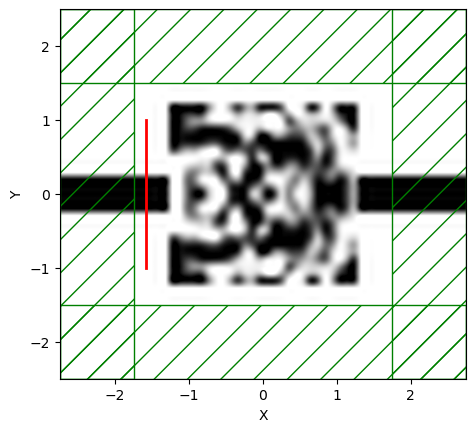

In [18]:
## update the epsilon weight with the optimized x
design_variables.update_weights(mapping(x, eta_i, cur_beta // 2))
##
geometry = [
    mp.Block(
        center=mp.Vector3(x=-Sx / 4), material=Si, size=mp.Vector3(Sx / 2, 0.5, 0)
    ),  # horizontal waveguide
    mp.Block(
        center=mp.Vector3(x = Sx / 4), material=Si, size=mp.Vector3(Sx / 2, 0.5, 0)
    ),  # right waveguide
    mp.Block(
        center=design_region.center, size=design_region.size, material=design_variables
    ), 
]

##
## source 
src = mp.ContinuousSource(frequency=fcen)
source = [
    mp.EigenModeSource(
        src,
        eig_band=1,
        direction=mp.NO_DIRECTION,
        eig_kpoint=kpoint,
        size=source_size,
        center=source_center,
    )
]
##
sim_opt = mp.Simulation(
    cell_size=cell_size,
    boundary_layers=pml_layers,
    geometry=geometry,
    sources=source,
    eps_averaging=False,
    default_material=SiO2,
    resolution=resolution,
)
##
plt.figure()
sim_opt.plot2D()
plt.show()

In [20]:
## animation
from IPython.display import Video
import mycmapls as ms# colormap defined in mycmapls.py

f = plt.figure(dpi=100)
Animate = mp.Animate2D(fields=mp.Ez, f=f, realtime=False, normalize=True
                      , field_parameters={'alpha':0.8,'cmap':ms.bifan},
                      eps_parameters={'alpha':1,'cmap':'binary'})
plt.close()
sim_opt.run(mp.at_every(0.2, Animate), until=100)
plt.close()
filename = "filter_id.mp4"
Animate.to_mp4(10, filename)
Video(filename)

FloatProgress(value=0.0, description='0% done ')